In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline

import sys
sys.version

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]'

# Breakdown the function get_data(symbol)

## Step 1 - Create features

In [2]:
symbol = 'SPX'  # S&P500

ti = TechIndicators(key='4BTFICZGTPWZRRQS', output_format='pandas')
sma, _ = ti.get_sma(symbol=symbol, interval='daily')
wma, _ = ti.get_wma(symbol=symbol, interval='daily')
ema, _ = ti.get_ema(symbol=symbol, interval='daily')
macd, _ = ti.get_macd(symbol=symbol, interval='daily')

In [3]:
sma.head(2)

,SMA
date,
2000-01-31,1425.5855
2000-02-01,1423.2885


## Create master dataframes

In [4]:
# Combine all feature data columns to a dataframe
tech_ind = pd.concat([sma, ema, macd], axis=1)

ts = TimeSeries(key='4BTFICZGTPWZRRQS', output_format='pandas')
close = ts.get_daily(symbol=symbol, outputsize='full')[0]['4. close']   # compact/full

# If today's close is lower than yesterday's, meaning price drops, then marked as 0, or 1, meaning price rises.
direction = (close > close.shift()).astype(int)

# Set target as the next day's direction change status
target = direction.shift(-1).fillna(0).astype(int)
target.name = 'target'

# Create a final master dataframe including all features, real price and target columns
data = pd.concat([tech_ind, close, target], axis=1)

In [5]:
data[17:22]

,SMA,EMA,MACD,MACD_Signal,MACD_Hist,4. close,target
2000-01-27,NaN,NaN,NaN,NaN,NaN,1398.5601,0
2000-01-28,NaN,NaN,NaN,NaN,NaN,1360.1600,1
2000-01-31,1425.5855,1425.5855,NaN,NaN,NaN,1394.4600,1
2000-02-01,1423.2885,1424.0326,NaN,NaN,NaN,1409.2800,0
2000-02-02,1423.7735,1422.6124,NaN,NaN,NaN,1409.1200,1


In [82]:
def get_data(symbol):

    # Technical Indicators
    ti = TechIndicators(key='4BTFICZGTPWZRRQS', output_format='pandas')
    sma, _ = ti.get_sma(symbol=symbol, interval='daily')
    wma, _ = ti.get_wma(symbol=symbol, interval='daily')
    ema, _ = ti.get_ema(symbol=symbol, interval='daily')
    macd, _ = ti.get_macd(symbol=symbol, interval='daily')
#     stoch, _ = ti.get_stoch(symbol=symbol, interval='daily')
#     rsi, _ = ti.get_rsi(symbol=symbol, interval='daily')
#     adx, _ = ti.get_adx(symbol=symbol, interval='daily')
#     cci, _ = ti.get_cci(symbol=symbol, interval='daily')
#     aroon, _ = ti.get_aroon(symbol=symbol, interval='daily')
#     bbands, _ = ti.get_bbands(symbol='SPX', interval='daily')
#     ad, _ = ti.get_ad(symbol='SPX', interval='daily')
#     obv, _ = ti.get_obv(symbol='SPX', interval='daily')
#     mom, _ = ti.get_mom(symbol='SPX', interval='daily')
#     willr, _ = ti.get_willr(symbol='SPX', interval='daily')
    tech_ind = pd.concat([sma, ema, macd], axis=1)

    ts = TimeSeries(key='4BTFICZGTPWZRRQS', output_format='pandas')
    close = ts.get_daily(symbol=symbol, outputsize='full')[0]['4. close']   # compact/full
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'

    data = pd.concat([tech_ind, close, target], axis=1)

    return data


# def get_indicators(data, n):

#     hh = data['2. high'].rolling(n).max()
#     ll = data['3. low'].rolling(n).min()
#     up, dw = data['4. close'].diff(), -data['4. close'].diff()
#     up[up<0], dw[dw<0] = 0, 0
#     macd = data['4. close'].ewm(12).mean() - data['4. close'].ewm(26).mean()
#     macd_signal = macd.ewm(9).mean()
#     tp = (data['2. high'] + data['3. low'] + data['4. close']) / 3
#     tp_ma = tp.rolling(n).mean()
#     indicators = pd.DataFrame(data=0, index=data.index,
#                               columns=['sma', 'ema', 'macd',
# #                                        'momentum'
# #                                        'sto_k', 'sto_d', 'rsi',
# #                                         'lw_r', 'a/d', 'cci'
#                                       ])
#     indicators['sma'] = data['4. close'].rolling(10).mean()
#     indicators['ema'] = data['4. close'].ewm(10).mean()
# #     indicators['momentum'] = data['close'] - data['close'].shift(n)
# #     indicators['sto_k'] = (data['close'] - ll) / (hh - ll) * 100
# #     indicators['sto_d'] = indicators['sto_k'].rolling(n).mean()
# #     indicators['rsi'] = 100 - 100 / (1 + up.rolling(14).mean() / dw.rolling(14).mean())
#     indicators['macd'] = macd - macd_signal
# #     indicators['lw_r'] = (hh - data['close']) / (hh - ll) * 100
# #     indicators['a/d'] = (data['high'] - data['close'].shift()) / (data['high'] - data['low'])
# #     indicators['cci'] = (tp - tp_ma) / (0.015 * tp.rolling(n).apply(lambda x: np.std(x)))

#     return indicators


def rebalance(unbalanced_data):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data.target==0] # get all all down days
    data_majority = unbalanced_data[unbalanced_data.target==1] # get all up days

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])

    data_upsampled.sort_index(inplace=True)

    # Display new class counts
    data_upsampled.target.value_counts()

    return data_upsampled


def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm

def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))

In [7]:
data_minority = data[data.target==0] # get all all down days, which has the smaller number of days
data_majority = data[data.target==1] # get all up days, which has the larger number of days

In [8]:
n_samples = len(data_majority) # get the number of up days
data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)

In [9]:
len(data_majority)

2548

In [10]:
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

In [11]:
# Sort the data into correct date order
data_upsampled.sort_index(inplace=True)

In [12]:
data_upsampled.head(10)

,SMA,EMA,MACD,MACD_Signal,MACD_Hist,4. close,target
2000-01-04,NaN,NaN,NaN,NaN,NaN,1399.4200,1
2000-01-05,NaN,NaN,NaN,NaN,NaN,1402.1100,1
2000-01-06,NaN,NaN,NaN,NaN,NaN,1403.4500,1
2000-01-07,NaN,NaN,NaN,NaN,NaN,1441.4700,1
2000-01-10,NaN,NaN,NaN,NaN,NaN,1457.6000,0
2000-01-11,NaN,NaN,NaN,NaN,NaN,1438.5601,0
2000-01-12,NaN,NaN,NaN,NaN,NaN,1432.2500,1
2000-01-13,NaN,NaN,NaN,NaN,NaN,1449.6801,1
2000-01-14,NaN,NaN,NaN,NaN,NaN,1465.1500,0
2000-01-14,NaN,NaN,NaN,NaN,NaN,1465.1500,0


In [48]:
data_majority.head(10)

,SMA,EMA,MACD,MACD_Signal,MACD_Hist,4. close,target
2000-01-04,NaN,NaN,NaN,NaN,NaN,1399.4200,1
2000-01-05,NaN,NaN,NaN,NaN,NaN,1402.1100,1
2000-01-06,NaN,NaN,NaN,NaN,NaN,1403.4500,1
2000-01-07,NaN,NaN,NaN,NaN,NaN,1441.4700,1
2000-01-12,NaN,NaN,NaN,NaN,NaN,1432.2500,1
2000-01-13,NaN,NaN,NaN,NaN,NaN,1449.6801,1
2000-01-18,NaN,NaN,NaN,NaN,NaN,1455.1400,1
2000-01-24,NaN,NaN,NaN,NaN,NaN,1401.5300,1
2000-01-28,NaN,NaN,NaN,NaN,NaN,1360.1600,1
2000-01-31,1425.5855,1425.5855,NaN,NaN,NaN,1394.4600,1


In [49]:
data_minority.head(10)

,SMA,EMA,MACD,MACD_Signal,MACD_Hist,4. close,target
2000-01-03,NaN,NaN,NaN,NaN,NaN,1455.2200,0
2000-01-10,NaN,NaN,NaN,NaN,NaN,1457.6000,0
2000-01-11,NaN,NaN,NaN,NaN,NaN,1438.5601,0
2000-01-14,NaN,NaN,NaN,NaN,NaN,1465.1500,0
2000-01-19,NaN,NaN,NaN,NaN,NaN,1455.9000,0
2000-01-20,NaN,NaN,NaN,NaN,NaN,1445.5699,0
2000-01-21,NaN,NaN,NaN,NaN,NaN,1441.3600,0
2000-01-25,NaN,NaN,NaN,NaN,NaN,1410.0300,0
2000-01-26,NaN,NaN,NaN,NaN,NaN,1404.0900,0
2000-01-27,NaN,NaN,NaN,NaN,NaN,1398.5601,0


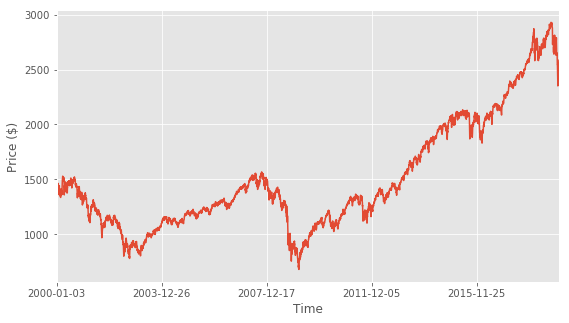

In [18]:
# Part 1:

symbol = 'SPX'  # S&P500
data = get_data(symbol)
data.tail(10)
data.describe()
ax = data['4. close'].plot(figsize=(9, 5))
ax.set_ylabel("Price ($)")
ax.set_xlabel("Time")
plt.show()

In [19]:
# Part 2:

data_train = data['2011-01-01':'2017-01-01']
# Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
data_train = rebalance(data_train)
# y as the label target 
y = data_train.target
# X as the dataframe with their values to be normalized
X = data_train.drop('target', axis=1)
X = normalize(X)

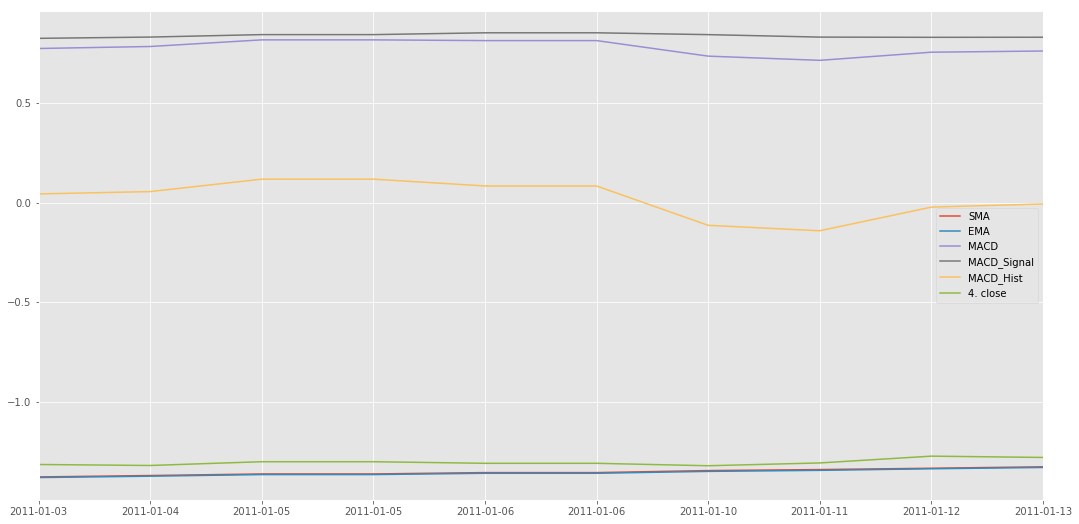

In [50]:
X.head(10).plot(figsize = (18, 9))

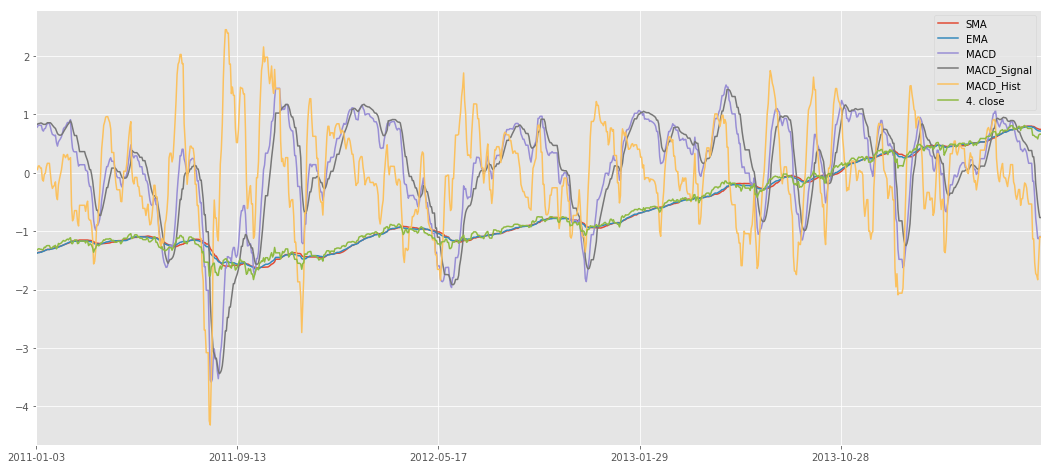

In [20]:
# Plotted chart based on normalized dataframe values. 
X.head(1000).plot(figsize = (18, 8))

In [51]:
data_val = data['2017-01-01':]
# y_val as the label target in the validation period
y_val = data_val.target
# X_val as the dataframe with their values to be normalized in the validation period
X_val = data_val.drop('target', axis=1)
# normalize
X_val = normalize(X_val)

In [52]:
# Part 3"
# Machine Learning

# Train test split
import sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

In [53]:
X_train.sort_index().head(10)

,SMA,EMA,MACD,MACD_Signal,MACD_Hist,4. close
2011-01-03,-1.377104,-1.380328,0.773812,0.824796,0.043648,-1.314685
2011-01-04,-1.370070,-1.373407,0.783827,0.831180,0.055427,-1.319650
2011-01-06,-1.355372,-1.358802,0.813473,0.852625,0.083602,-1.308798
2011-01-06,-1.355372,-1.358802,0.813473,0.852625,0.083602,-1.308798
2011-01-10,-1.345236,-1.349317,0.735456,0.843434,-0.114014,-1.320988
2011-01-12,-1.333525,-1.336169,0.755222,0.829916,-0.022562,-1.272793
2011-01-13,-1.326274,-1.329592,0.761168,0.830354,-0.006792,-1.279334
2011-01-14,-1.318749,-1.320943,0.810481,0.841428,0.104399,-1.251148
2011-01-18,-1.311113,-1.312610,0.846573,0.858133,0.163274,-1.245856
2011-01-18,-1.311113,-1.312610,0.846573,0.858133,0.163274,-1.245856


In [54]:
len(X_train)

1351

In [55]:
X_test.sort_index().head(10)

,SMA,EMA,MACD,MACD_Signal,MACD_Hist,4. close
2011-01-05,-1.362181,-1.365334,0.817171,0.843542,0.117861,-1.300741
2011-01-05,-1.362181,-1.365334,0.817171,0.843542,0.117861,-1.300741
2011-01-11,-1.340153,-1.344130,0.714407,0.830998,-0.141326,-1.306925
2011-01-19,-1.305908,-1.308801,0.781754,0.857398,-0.018981,-1.284805
2011-01-31,-1.269650,-1.278600,0.458184,0.674057,-0.459259,-1.272317
2011-02-07,-1.242062,-1.242782,0.683326,0.670556,0.189530,-1.174410
2011-03-09,-1.150950,-1.168314,0.018150,0.205481,-0.485255,-1.171526
2011-03-24,-1.209831,-1.219805,-0.670239,-0.729747,0.002291,-1.202328
2011-04-06,-1.200118,-1.169993,0.229579,-0.080489,0.862524,-1.125382
2011-04-07,-1.194381,-1.165076,0.257850,-0.007448,0.752023,-1.131417


In [56]:
len(X_test)

271

In [57]:
len(y_train.sort_index())

1351

In [58]:
len(y_test.sort_index())

271

In [59]:
models = [RandomForestClassifier(random_state=5)]

for model in models:
    model.fit(X_train, y_train)

scores(models, X_test, y_test)

Accuracy Score: 68.27 %
F1 Score: 0.6446
Area Under ROC Curve Score: 0.6816


In [60]:
models

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=5, verbose=0, warm_start=False)]

In [61]:
# Trying to fix the bracket issue:
grid_data = [
              # Model 1 - RandomForestClassifier's parameters:
              {'n_estimators': [10, 50, 100],
               'criterion': ['gini', 'entropy'],
               'max_depth': [None, 10, 50, 100],
               'min_samples_split': [2, 5, 10],
               'random_state': [5]}]

models_grid = list()

In [131]:
# Og
# grid_data = [[{'kernel': ['poly'], 'degree': [1, 2, 3, 4], 'C': [0.1, 1, 10, 100], 'random_state': [5]},
#               {'kernel': ['rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100], 'random_state': [5]}],
#               {'n_estimators': [10, 50, 100],
#                'criterion': ['gini', 'entropy'],
#                'max_depth': [None, 10, 50, 100],
#                'min_samples_split': [2, 5, 10],
#                'random_state': [5]},
#               {'hidden_layer_sizes': [10, 50, 100],
#                'activation': ['identity', 'logistic', 'tanh', 'relu'],
#                'solver': ['lbfgs', 'sgd', 'adam'],
#                'learning_rate': ['constant', 'invscaling', 'adaptive'],
#                'max_iter': [200, 400, 800],
#                'random_state': [5]}]

In [64]:
models[0]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [66]:
grid = GridSearchCV(models[0], grid_data[0], scoring='f1').fit(X_train, y_train)
print(grid.best_params_)

{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'criterion': 'entropy', 'random_state': 5}


In [68]:
model = grid.best_estimator_

In [98]:
for model in models:
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("model", model)

Accuracy Score: 92.60 %
F1 Score: 0.9241
Area Under ROC Curve Score: 0.9260
----------------------------------------------------
model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


In [96]:
# Validation data
for model in models:
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("model", model)

Accuracy Score: 49.61 %
F1 Score: 0.5206
Area Under ROC Curve Score: 0.4958
----------------------------------------------------
model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


Testing Model1...


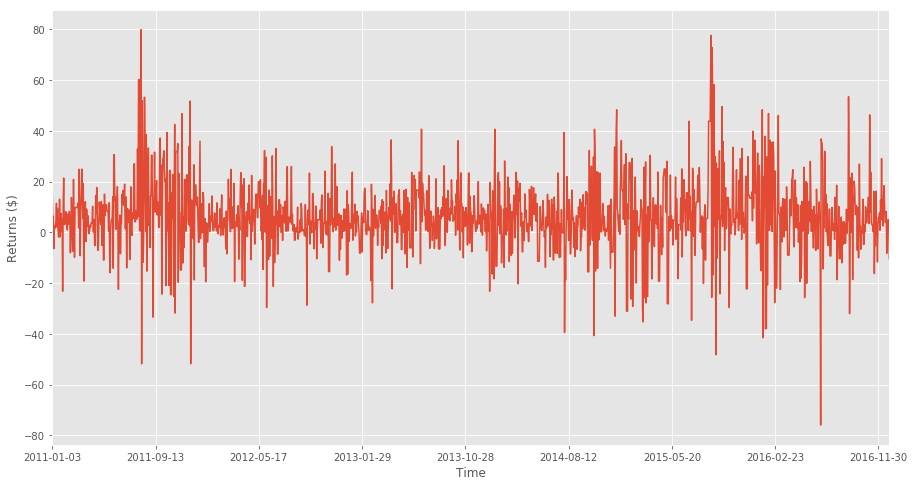

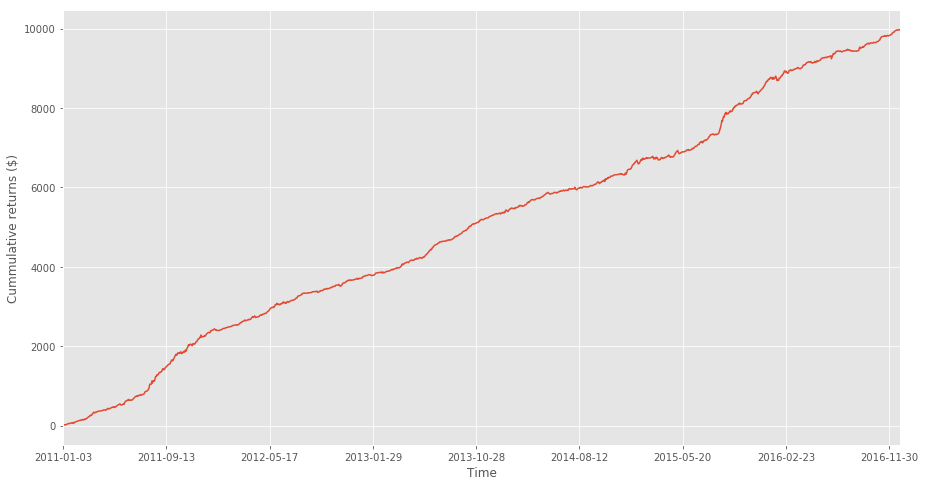

In [105]:
# See backtest of trained overfitted results:

# Trading system
for i in range(1):
    print ("======================================================================")
    print ("Testing Model{}...".format(i+1))
    rf_model = models_grid[i]
    y_pred = rf_model.predict(X)
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['4. close'].diff()
    data_returns = data_returns[X.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()
    equity = model_returns.sum()
    start_close = data["4. close"][X.index[0]]
    performance = equity / start_close * 100
    ax = model_returns.plot(figsize=(15, 8))
    ax.set_ylabel("Returns ($)")
    ax.set_xlabel("Time")
    plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()

Testing Model1...


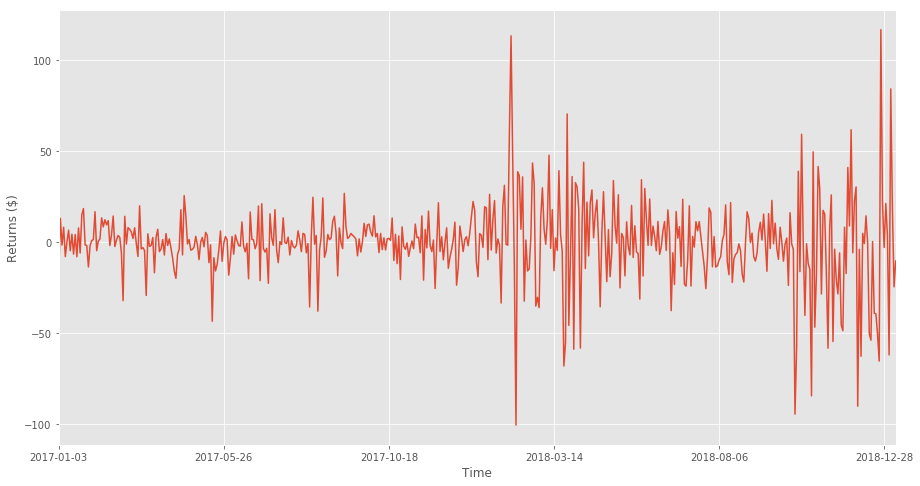

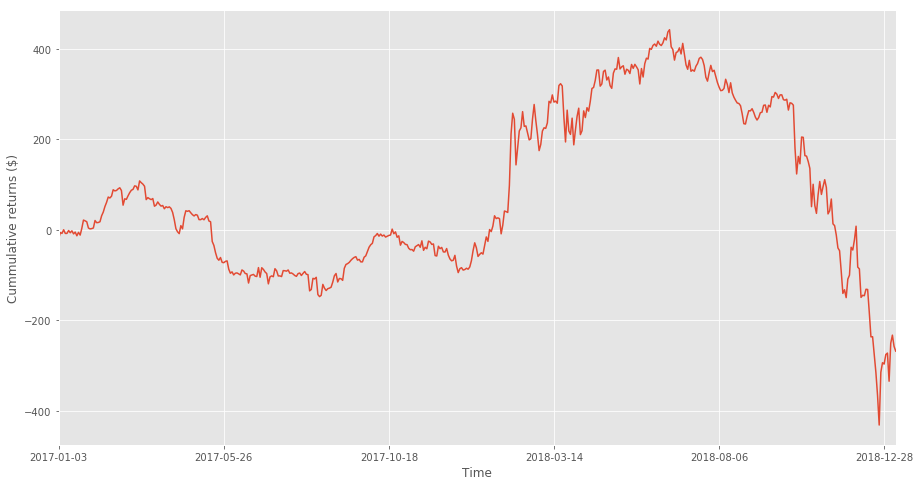

In [107]:
# Trading system: testing real performance:
for i in range(1):
    print ("======================================================================")
    print ("Testing Model{}...".format(i+1))
    rf_model = models_grid[i]
    y_pred = rf_model.predict(X_val)
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data['4. close'].diff()
    data_returns = data_returns[X_val.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum()
    equity = model_returns.sum()
    start_close = data["4. close"][X_val.index[0]]
    performance = equity / start_close * 100
    ax = model_returns.plot(figsize=(15, 8))
    ax.set_ylabel("Returns ($)")
    ax.set_xlabel("Time")
    plt.show()
    ax = model_cum.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns ($)")
    ax.set_xlabel("Time")
    plt.show()

# Summarize and explore ML algos' packages/paras with python

## OLS

https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

In [33]:
# OLS:
import statsmodels.formula.api as sm

In [23]:
sm.ols?

sm.ols(formula, data, subset=None, drop_cols=None, *args, **kwargs)

## lasso ridge and elastic

https://www.ricequant.com/community/topic/3951

In [26]:
from sklearn import linear_model

## Group lasso

## Ridge

##  Elastic net

## nnls

## svm

https://quant.la/Article/View/33/%E7%94%A8Python-%E5%AE%9E%E7%8E%B0%E4%B8%80%E4%B8%AA-SVM-%E5%88%86%E7%B1%BB%E5%99%A8-%E7%AD%96%E7%95%A5.html

In [34]:
from sklearn import svm

In [36]:
svm.LinearSVC?

## svr

## markov

## hmm

In [2]:
from hmmlearn.hmm import GaussianHMM

In [3]:
GaussianHMM?

In [ ]:
model = GaussionHMM(n_components = n, covariance_type = 'full', n_iter=2000).fit()

## gbdt

## neural network

## genetic algo

## decision tree

## random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
RandomForestClassifier?

## PCA

## DL